In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths
import sys

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training
from sklearn.model_selection import train_test_split

BATCH_SIZE = 512

mixed_precision.set_global_policy('mixed_float16')


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

2022-05-30 05:42:35.409712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 05:42:35.457882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 05:42:35.458098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-30 05:42:35.710478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Early blast             615
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
3 Cell                  303
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

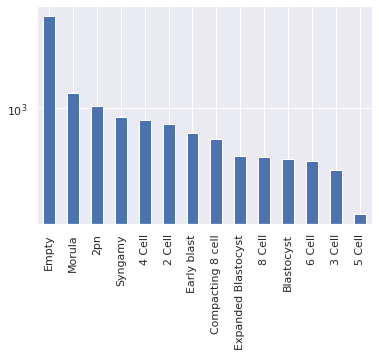

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
373         Early blast             5940
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Early blast',
 'Blastocyst',
 'Empty']

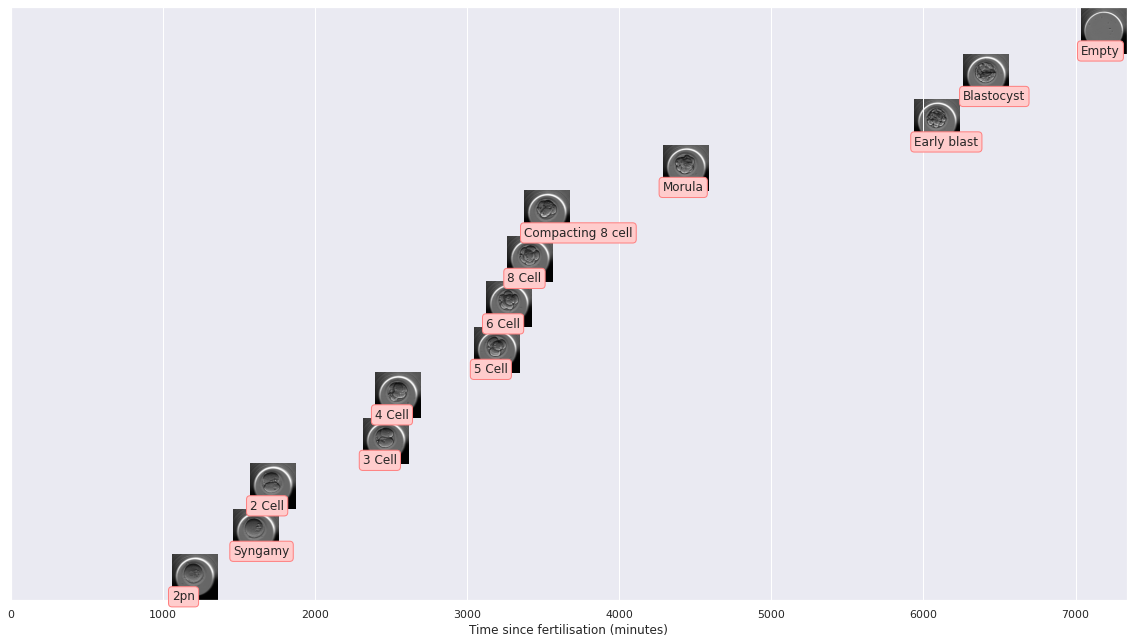

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
train = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    label_mode = 'categorical',
    shuffle = False
)

Found 13626 files belonging to 14 classes.


2022-05-30 05:42:37.858804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 05:42:37.859628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 05:42:37.859847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 05:42:37.859973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
classes = train.class_names
classes

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [9]:
data_augmentation = keras.layers.RandomFlip("horizontal_and_vertical")
data_augmentation

In [10]:
train_aug = train.map(lambda x, y: (data_augmentation(x), y))

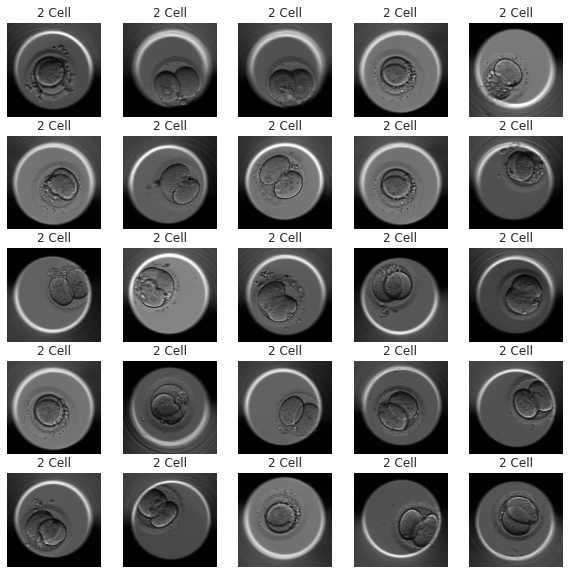

In [11]:
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_aug))
images = images.numpy().astype("uint8")
np.random.shuffle(images)
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(classes[labels[i].numpy().argmax()])
    plt.axis("off")

In [12]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299,299,3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
outputs = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#x = keras.layers.Dense(512, activation='relu')(x)
#outputs = keras.layers.Dense(len(classes), activation='softmax')(x)
base_model = keras.Model(inputs, outputs)

base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 20,861,480
Trainable params: 0
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
extracted_features = base_model.predict(train_aug)

2022-05-30 05:42:46.996052: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-05-30 05:42:47.895549: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


27/27 [==============================] - 30s 959ms/step


In [14]:
extracted_features.shape

(13626, 2048)

In [15]:
y = np.vstack([y for x,y in train])
y.shape

(13626, 14)

In [16]:
model = keras.Sequential([
    keras.layers.Input(shape=(2048)),
    keras.layers.Dense(len(classes), activation="softmax")
])
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                28686     
                                                                 
Total params: 28,686
Trainable params: 28,686
Non-trainable params: 0
_________________________________________________________________


In [17]:
x_train, x_test, y_train, y_test = train_test_split(extracted_features, y, test_size=.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10900, 2048), (10900, 14), (2726, 2048), (2726, 14))

In [18]:
%%time
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_test, y_test),
                    epochs=500,
                    verbose=0,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',patience=50, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/22           ETA: ?s - 

Epoch 2/500


0/22           ETA: ?s - 

Epoch 3/500


0/22           ETA: ?s - 

Epoch 4/500


0/22           ETA: ?s - 

Epoch 5/500


0/22           ETA: ?s - 

Epoch 6/500


0/22           ETA: ?s - 

Epoch 7/500


0/22           ETA: ?s - 

Epoch 8/500


0/22           ETA: ?s - 

Epoch 9/500


0/22           ETA: ?s - 

Epoch 10/500


0/22           ETA: ?s - 

Epoch 11/500


0/22           ETA: ?s - 

Epoch 12/500


0/22           ETA: ?s - 

Epoch 13/500


0/22           ETA: ?s - 

Epoch 14/500


0/22           ETA: ?s - 

Epoch 15/500


0/22           ETA: ?s - 

Epoch 16/500


0/22           ETA: ?s - 

Epoch 17/500


0/22           ETA: ?s - 

Epoch 18/500


0/22           ETA: ?s - 

Epoch 19/500


0/22           ETA: ?s - 

Epoch 20/500


0/22           ETA: ?s - 

Epoch 21/500


0/22           ETA: ?s - 

Epoch 22/500


0/22           ETA: ?s - 

Epoch 23/500


0/22           ETA: ?s - 

Epoch 24/500


0/22           ETA: ?s - 

Epoch 25/500


0/22           ETA: ?s - 

Epoch 26/500


0/22           ETA: ?s - 

Epoch 27/500


0/22           ETA: ?s - 

Epoch 28/500


0/22           ETA: ?s - 

Epoch 29/500


0/22           ETA: ?s - 

Epoch 30/500


0/22           ETA: ?s - 

Epoch 31/500


0/22           ETA: ?s - 

Epoch 32/500


0/22           ETA: ?s - 

Epoch 33/500


0/22           ETA: ?s - 

Epoch 34/500


0/22           ETA: ?s - 

Epoch 35/500


0/22           ETA: ?s - 

Epoch 36/500


0/22           ETA: ?s - 

Epoch 37/500


0/22           ETA: ?s - 

Epoch 38/500


0/22           ETA: ?s - 

Epoch 39/500


0/22           ETA: ?s - 

Epoch 40/500


0/22           ETA: ?s - 

Epoch 41/500


0/22           ETA: ?s - 

Epoch 42/500


0/22           ETA: ?s - 

Epoch 43/500


0/22           ETA: ?s - 

Epoch 44/500


0/22           ETA: ?s - 

Epoch 45/500


0/22           ETA: ?s - 

Epoch 46/500


0/22           ETA: ?s - 

Epoch 47/500


0/22           ETA: ?s - 

Epoch 48/500


0/22           ETA: ?s - 

Epoch 49/500


0/22           ETA: ?s - 

Epoch 50/500


0/22           ETA: ?s - 

Epoch 51/500


0/22           ETA: ?s - 

Epoch 52/500


0/22           ETA: ?s - 

Epoch 53/500


0/22           ETA: ?s - 

Epoch 54/500


0/22           ETA: ?s - 

Epoch 55/500


0/22           ETA: ?s - 

Epoch 56/500


0/22           ETA: ?s - 

Epoch 57/500


0/22           ETA: ?s - 

Epoch 58/500


0/22           ETA: ?s - 

Epoch 59/500


0/22           ETA: ?s - 

Epoch 60/500


0/22           ETA: ?s - 

Epoch 61/500


0/22           ETA: ?s - 

Epoch 62/500


0/22           ETA: ?s - 

Epoch 63/500


0/22           ETA: ?s - 

Epoch 64/500


0/22           ETA: ?s - 

Epoch 65/500


0/22           ETA: ?s - 

Epoch 66/500


0/22           ETA: ?s - 

Epoch 67/500


0/22           ETA: ?s - 

Epoch 68/500


0/22           ETA: ?s - 

Epoch 69/500


0/22           ETA: ?s - 

Epoch 70/500


0/22           ETA: ?s - 

Epoch 71/500


0/22           ETA: ?s - 

Epoch 72/500


0/22           ETA: ?s - 

Epoch 73/500


0/22           ETA: ?s - 

Epoch 74/500


0/22           ETA: ?s - 

Epoch 75/500


0/22           ETA: ?s - 

Epoch 76/500


0/22           ETA: ?s - 

Epoch 77/500


0/22           ETA: ?s - 

Epoch 78/500


0/22           ETA: ?s - 

Epoch 79/500


0/22           ETA: ?s - 

Epoch 80/500


0/22           ETA: ?s - 

Epoch 81/500


0/22           ETA: ?s - 

Epoch 82/500


0/22           ETA: ?s - 

Epoch 83/500


0/22           ETA: ?s - 

Epoch 84/500


0/22           ETA: ?s - 

Epoch 85/500


0/22           ETA: ?s - 

Epoch 86/500


0/22           ETA: ?s - 

Epoch 87/500


0/22           ETA: ?s - 

Epoch 88/500


0/22           ETA: ?s - 

Epoch 89/500


0/22           ETA: ?s - 

Epoch 90/500


0/22           ETA: ?s - 

Epoch 91/500


0/22           ETA: ?s - 

Epoch 92/500


0/22           ETA: ?s - 

Epoch 93/500


0/22           ETA: ?s - 

Epoch 94/500


0/22           ETA: ?s - 

Epoch 95/500


0/22           ETA: ?s - 

Epoch 96/500


0/22           ETA: ?s - 

Epoch 97/500


0/22           ETA: ?s - 

Epoch 98/500


0/22           ETA: ?s - 

Epoch 99/500


0/22           ETA: ?s - 

Epoch 100/500


0/22           ETA: ?s - 

Epoch 101/500


0/22           ETA: ?s - 

Epoch 102/500


0/22           ETA: ?s - 

Epoch 103/500


0/22           ETA: ?s - 

Epoch 104/500


0/22           ETA: ?s - 

Epoch 105/500


0/22           ETA: ?s - 

Epoch 106/500


0/22           ETA: ?s - 

Epoch 107/500


0/22           ETA: ?s - 

Epoch 108/500


0/22           ETA: ?s - 

Epoch 109/500


0/22           ETA: ?s - 

Epoch 110/500


0/22           ETA: ?s - 

Epoch 111/500


0/22           ETA: ?s - 

Epoch 112/500


0/22           ETA: ?s - 

Epoch 113/500


0/22           ETA: ?s - 

Epoch 114/500


0/22           ETA: ?s - 

Epoch 115/500


0/22           ETA: ?s - 

Epoch 116/500


0/22           ETA: ?s - 

Epoch 117/500


0/22           ETA: ?s - 

Epoch 118/500


0/22           ETA: ?s - 

Epoch 119/500


0/22           ETA: ?s - 

Epoch 120/500


0/22           ETA: ?s - 

Epoch 121/500


0/22           ETA: ?s - 

Epoch 122/500


0/22           ETA: ?s - 

Epoch 123/500


0/22           ETA: ?s - 

Epoch 124/500


0/22           ETA: ?s - 

Epoch 125/500


0/22           ETA: ?s - 

Epoch 126/500


0/22           ETA: ?s - 

Epoch 127/500


0/22           ETA: ?s - 

Epoch 128/500


0/22           ETA: ?s - 

Epoch 129/500


0/22           ETA: ?s - 

Epoch 130/500


0/22           ETA: ?s - 

Epoch 131/500


0/22           ETA: ?s - 

Epoch 132/500


0/22           ETA: ?s - 

Epoch 133/500


0/22           ETA: ?s - 

Epoch 134/500


0/22           ETA: ?s - 

Epoch 135/500


0/22           ETA: ?s - 

Epoch 136/500


0/22           ETA: ?s - 

Epoch 137/500


0/22           ETA: ?s - 

Epoch 138/500


0/22           ETA: ?s - 

Epoch 139/500


0/22           ETA: ?s - 

Epoch 140/500


0/22           ETA: ?s - 

Epoch 141/500


0/22           ETA: ?s - 

Epoch 142/500


0/22           ETA: ?s - 

Epoch 143/500


0/22           ETA: ?s - 

Epoch 144/500


0/22           ETA: ?s - 

Epoch 145/500


0/22           ETA: ?s - 

Epoch 146/500


0/22           ETA: ?s - 

Epoch 147/500


0/22           ETA: ?s - 

Epoch 148/500


0/22           ETA: ?s - 

Epoch 149/500


0/22           ETA: ?s - 

Epoch 150/500


0/22           ETA: ?s - 

Epoch 151/500


0/22           ETA: ?s - 

Epoch 152/500


0/22           ETA: ?s - 

Epoch 153/500


0/22           ETA: ?s - 

Epoch 154/500


0/22           ETA: ?s - 

Epoch 155/500


0/22           ETA: ?s - 

Epoch 156/500


0/22           ETA: ?s - 

Epoch 157/500


0/22           ETA: ?s - 

Epoch 158/500


0/22           ETA: ?s - 

Epoch 159/500


0/22           ETA: ?s - 

Epoch 160/500


0/22           ETA: ?s - 

Epoch 161/500


0/22           ETA: ?s - 

Epoch 162/500


0/22           ETA: ?s - 

Epoch 163/500


0/22           ETA: ?s - 

Epoch 164/500


0/22           ETA: ?s - 

Epoch 165/500


0/22           ETA: ?s - 

Epoch 166/500


0/22           ETA: ?s - 

Epoch 167/500


0/22           ETA: ?s - 

Epoch 168/500


0/22           ETA: ?s - 

Epoch 169/500


0/22           ETA: ?s - 

Epoch 170/500


0/22           ETA: ?s - 

Epoch 171/500


0/22           ETA: ?s - 

Epoch 172/500


0/22           ETA: ?s - 

Epoch 173/500


0/22           ETA: ?s - 

Epoch 174/500


0/22           ETA: ?s - 

Epoch 175/500


0/22           ETA: ?s - 

Epoch 176/500


0/22           ETA: ?s - 

Epoch 177/500


0/22           ETA: ?s - 

Epoch 178/500


0/22           ETA: ?s - 

Epoch 179/500


0/22           ETA: ?s - 

Epoch 180/500


0/22           ETA: ?s - 

Epoch 181/500


0/22           ETA: ?s - 

Epoch 182/500


0/22           ETA: ?s - 

Epoch 183/500


0/22           ETA: ?s - 

Epoch 184/500


0/22           ETA: ?s - 

Epoch 185/500


0/22           ETA: ?s - 

Epoch 186/500


0/22           ETA: ?s - 

Epoch 187/500


0/22           ETA: ?s - 

Epoch 188/500


0/22           ETA: ?s - 

Epoch 189/500


0/22           ETA: ?s - 

Epoch 190/500


0/22           ETA: ?s - 

Epoch 191/500


0/22           ETA: ?s - 

Epoch 192/500


0/22           ETA: ?s - 

Epoch 193/500


0/22           ETA: ?s - 

Epoch 194/500


0/22           ETA: ?s - 

Epoch 195/500


0/22           ETA: ?s - 

Epoch 196/500


0/22           ETA: ?s - 

Epoch 197/500


0/22           ETA: ?s - 

Epoch 198/500


0/22           ETA: ?s - 

Epoch 199/500


0/22           ETA: ?s - 

Epoch 200/500


0/22           ETA: ?s - 

Epoch 201/500


0/22           ETA: ?s - 

Epoch 202/500


0/22           ETA: ?s - 

Epoch 203/500


0/22           ETA: ?s - 

Epoch 204/500


0/22           ETA: ?s - 

Epoch 205/500


0/22           ETA: ?s - 

Epoch 206/500


0/22           ETA: ?s - 

Epoch 207/500


0/22           ETA: ?s - 

Epoch 208/500


0/22           ETA: ?s - 

Epoch 209/500


0/22           ETA: ?s - 

Epoch 210/500


0/22           ETA: ?s - 

Epoch 211/500


0/22           ETA: ?s - 

Epoch 212/500


0/22           ETA: ?s - 

Epoch 213/500


0/22           ETA: ?s - 

Epoch 214/500


0/22           ETA: ?s - 

Epoch 215/500


0/22           ETA: ?s - 

Epoch 216/500


0/22           ETA: ?s - 

Epoch 217/500


0/22           ETA: ?s - 

Epoch 218/500


0/22           ETA: ?s - 

Epoch 219/500


0/22           ETA: ?s - 

Epoch 220/500


0/22           ETA: ?s - 

Epoch 221/500


0/22           ETA: ?s - 

Epoch 222/500


0/22           ETA: ?s - 

Epoch 223/500


0/22           ETA: ?s - 

Epoch 224/500


0/22           ETA: ?s - 

Epoch 225/500


0/22           ETA: ?s - 

Epoch 226/500


0/22           ETA: ?s - 

Epoch 227/500


0/22           ETA: ?s - 

Epoch 228/500


0/22           ETA: ?s - 

Epoch 229/500


0/22           ETA: ?s - 

Epoch 230/500


0/22           ETA: ?s - 

Epoch 231/500


0/22           ETA: ?s - 

Epoch 232/500


0/22           ETA: ?s - 

Epoch 233/500


0/22           ETA: ?s - 

Epoch 234/500


0/22           ETA: ?s - 

Epoch 235/500


0/22           ETA: ?s - 

Epoch 236/500


0/22           ETA: ?s - 

Epoch 237/500


0/22           ETA: ?s - 

Epoch 238/500


0/22           ETA: ?s - 

Epoch 239/500


0/22           ETA: ?s - 

Epoch 240/500


0/22           ETA: ?s - 

Epoch 241/500


0/22           ETA: ?s - 

Epoch 242/500


0/22           ETA: ?s - 

Epoch 243/500


0/22           ETA: ?s - 

Epoch 244/500


0/22           ETA: ?s - 

Epoch 245/500


0/22           ETA: ?s - 

Epoch 246/500


0/22           ETA: ?s - 

Epoch 247/500


0/22           ETA: ?s - 

Epoch 248/500


0/22           ETA: ?s - 

Epoch 249/500


0/22           ETA: ?s - 

Epoch 250/500


0/22           ETA: ?s - 

Epoch 251/500


0/22           ETA: ?s - 

Epoch 252/500


0/22           ETA: ?s - 

Epoch 253/500


0/22           ETA: ?s - 

Epoch 254/500


0/22           ETA: ?s - 

Epoch 255/500


0/22           ETA: ?s - 

Epoch 256/500


0/22           ETA: ?s - 

Epoch 257/500


0/22           ETA: ?s - 

Epoch 258/500


0/22           ETA: ?s - 

Epoch 259/500


0/22           ETA: ?s - 

Epoch 260/500


0/22           ETA: ?s - 

Epoch 261/500


0/22           ETA: ?s - 

Epoch 262/500


0/22           ETA: ?s - 

Epoch 263/500


0/22           ETA: ?s - 

Epoch 264/500


0/22           ETA: ?s - 

Epoch 265/500


0/22           ETA: ?s - 

Epoch 266/500


0/22           ETA: ?s - 

Epoch 267/500


0/22           ETA: ?s - 

Epoch 268/500


0/22           ETA: ?s - 

Epoch 269/500


0/22           ETA: ?s - 

Epoch 270/500


0/22           ETA: ?s - 

Epoch 271/500


0/22           ETA: ?s - 

Epoch 272/500


0/22           ETA: ?s - 

Epoch 273/500


0/22           ETA: ?s - 

Epoch 274/500


0/22           ETA: ?s - 

Epoch 275/500


0/22           ETA: ?s - 

Epoch 276/500


0/22           ETA: ?s - 

Epoch 277/500


0/22           ETA: ?s - 

Epoch 278/500


0/22           ETA: ?s - 

Epoch 279/500


0/22           ETA: ?s - 

Epoch 280/500


0/22           ETA: ?s - 

Epoch 281/500


0/22           ETA: ?s - 

Epoch 282/500


0/22           ETA: ?s - 

Epoch 283/500


0/22           ETA: ?s - 

Epoch 284/500


0/22           ETA: ?s - 

Epoch 285/500


0/22           ETA: ?s - 

Epoch 286/500


0/22           ETA: ?s - 

Epoch 287/500


0/22           ETA: ?s - 

Epoch 288/500


0/22           ETA: ?s - 

Epoch 289/500


0/22           ETA: ?s - 

Epoch 290/500


0/22           ETA: ?s - 

Epoch 291/500


0/22           ETA: ?s - 

Epoch 292/500


0/22           ETA: ?s - 

Epoch 293/500


0/22           ETA: ?s - 

Epoch 294/500


0/22           ETA: ?s - 

Epoch 295/500


0/22           ETA: ?s - 

Epoch 296/500


0/22           ETA: ?s - 

Epoch 297/500


0/22           ETA: ?s - 

Epoch 298/500


0/22           ETA: ?s - 

Epoch 299/500


0/22           ETA: ?s - 

Epoch 300/500


0/22           ETA: ?s - 

Epoch 301/500


0/22           ETA: ?s - 

Epoch 302/500


0/22           ETA: ?s - 

Epoch 303/500


0/22           ETA: ?s - 

Epoch 304/500


0/22           ETA: ?s - 

Epoch 305/500


0/22           ETA: ?s - 

Epoch 306/500


0/22           ETA: ?s - 

Epoch 307/500


0/22           ETA: ?s - 

Epoch 308/500


0/22           ETA: ?s - 

Epoch 309/500


0/22           ETA: ?s - 

Epoch 310/500


0/22           ETA: ?s - 

Epoch 311/500


0/22           ETA: ?s - 

Epoch 312/500


0/22           ETA: ?s - 

Epoch 313/500


0/22           ETA: ?s - 

Epoch 314/500


0/22           ETA: ?s - 

Epoch 315/500


0/22           ETA: ?s - 

Epoch 316/500


0/22           ETA: ?s - 

Epoch 317/500


0/22           ETA: ?s - 

Epoch 318/500


0/22           ETA: ?s - 

Epoch 319/500


0/22           ETA: ?s - 

Epoch 320/500


0/22           ETA: ?s - 

Epoch 321/500


0/22           ETA: ?s - 

Epoch 322/500


0/22           ETA: ?s - 

Epoch 323/500


0/22           ETA: ?s - 

Epoch 324/500


0/22           ETA: ?s - 

Epoch 325/500


0/22           ETA: ?s - 

Epoch 326/500


0/22           ETA: ?s - 

Epoch 327/500


0/22           ETA: ?s - 

Epoch 328/500


0/22           ETA: ?s - 

Epoch 329/500


0/22           ETA: ?s - 

Epoch 330/500


0/22           ETA: ?s - 

Epoch 331/500


0/22           ETA: ?s - 

Epoch 332/500


0/22           ETA: ?s - 

Epoch 333/500


0/22           ETA: ?s - 

Epoch 334/500


0/22           ETA: ?s - 

Epoch 335/500


0/22           ETA: ?s - 

Epoch 336/500


0/22           ETA: ?s - 

Epoch 337/500


0/22           ETA: ?s - 

Epoch 338/500


0/22           ETA: ?s - 

Epoch 339/500


0/22           ETA: ?s - 

Epoch 340/500


0/22           ETA: ?s - 

Epoch 341/500


0/22           ETA: ?s - 

Epoch 342/500


0/22           ETA: ?s - 

Epoch 343/500


0/22           ETA: ?s - 

Epoch 344/500


0/22           ETA: ?s - 

Epoch 345/500


0/22           ETA: ?s - 

Epoch 346/500


0/22           ETA: ?s - 

Epoch 347/500


0/22           ETA: ?s - 

Epoch 348/500


0/22           ETA: ?s - 

Epoch 349/500


0/22           ETA: ?s - 

Epoch 350/500


0/22           ETA: ?s - 

Epoch 351/500


0/22           ETA: ?s - 

Epoch 352/500


0/22           ETA: ?s - 

Epoch 353/500


0/22           ETA: ?s - 

Epoch 354/500


0/22           ETA: ?s - 

Epoch 355/500


0/22           ETA: ?s - 

Epoch 356/500


0/22           ETA: ?s - 

Epoch 357/500


0/22           ETA: ?s - 

Epoch 358/500


0/22           ETA: ?s - 

Epoch 359/500


0/22           ETA: ?s - 

Epoch 360/500


0/22           ETA: ?s - 

Epoch 361/500


0/22           ETA: ?s - 

Epoch 362/500


0/22           ETA: ?s - 

Epoch 363/500


0/22           ETA: ?s - 

Epoch 364/500


0/22           ETA: ?s - 

Epoch 365/500


0/22           ETA: ?s - 

Epoch 366/500


0/22           ETA: ?s - 

Epoch 367/500


0/22           ETA: ?s - 

Epoch 368/500


0/22           ETA: ?s - 

Epoch 369/500


0/22           ETA: ?s - 

CPU times: user 1min 40s, sys: 13.5 s, total: 1min 54s
Wall time: 1min 12s


<AxesSubplot:>

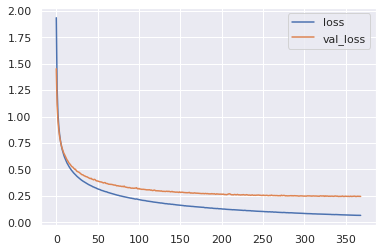

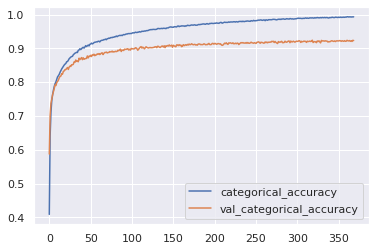

In [19]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [20]:
y_pred = model.predict(x_test)

86/86 [==============================] - 0s 2ms/step


In [21]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    2726.000000
mean        0.919922
std         0.141724
min         0.261719
25%         0.911255
50%         0.996582
75%         1.000000
max         1.000000
dtype: float64

In [22]:
true_classes = [classes[c] for c in y_test.argmax(axis=1)]
pd.Series(true_classes).value_counts()

Empty                  1166
Morula                  268
2pn                     230
4 Cell                  154
2 Cell                  148
Syngamy                 147
Early blast             115
Compacting 8 cell        97
Expanded Blastocyst      86
Blastocyst               77
6 Cell                   76
3 Cell                   70
8 Cell                   67
5 Cell                   25
dtype: int64

In [23]:
validation_df = pd.DataFrame()
validation_df["true_class"] = true_classes
validation_df["predicted_class"] = [classes[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,true_class,predicted_class,confidence
0,Blastocyst,Blastocyst,0.629883
1,4 Cell,4 Cell,0.723145
2,8 Cell,8 Cell,0.465088
3,Empty,Empty,1.000000
4,Empty,Empty,1.000000
...,...,...,...
2721,Empty,Empty,1.000000
2722,Empty,Empty,1.000000
2723,8 Cell,8 Cell,0.682129
2724,Empty,Empty,1.000000


In [24]:
validation_df.groupby("predicted_class").confidence.median()

predicted_class
2 Cell                 0.958984
2pn                    0.981445
3 Cell                 0.934570
4 Cell                 0.961914
5 Cell                 0.814453
6 Cell                 0.770508
8 Cell                 0.800781
Blastocyst             0.895996
Compacting 8 cell      0.759766
Early blast            0.928223
Empty                  1.000000
Expanded Blastocyst    0.985352
Morula                 0.918945
Syngamy                0.969727
Name: confidence, dtype: float16

In [25]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.91      0.86      0.88       148
                2pn       0.91      0.94      0.92       230
             3 Cell       0.84      0.81      0.83        70
             4 Cell       0.91      0.92      0.92       154
             5 Cell       0.53      0.36      0.43        25
             6 Cell       0.81      0.79      0.80        76
             8 Cell       0.80      0.82      0.81        67
         Blastocyst       0.79      0.78      0.78        77
  Compacting 8 cell       0.74      0.84      0.79        97
        Early blast       0.86      0.77      0.81       115
              Empty       1.00      1.00      1.00      1166
Expanded Blastocyst       0.91      0.86      0.89        86
             Morula       0.89      0.93      0.91       268
            Syngamy       0.89      0.89      0.89       147

           accuracy                           0.92      2726
          macro avg   

Text(30.499999999999993, 0.5, 'True')

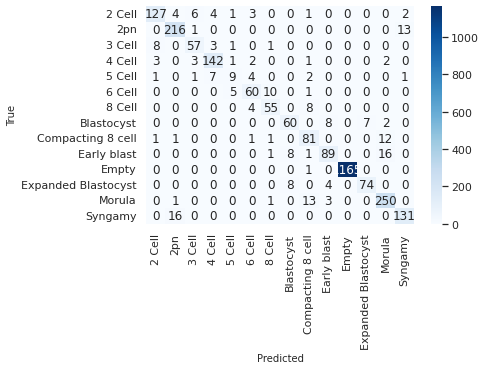

In [26]:
print(classification_report(validation_df["true_class"], validation_df["predicted_class"]))
s = sns.heatmap(
    confusion_matrix(validation_df["true_class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=classes,
    yticklabels=classes
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [31]:
model.save(f"models/{len(classes)}_class.h5")

In [28]:
test = tf.keras.utils.image_dataset_from_directory(
    "EmbryoLabeling/Labelers/One/M3169_S00470",
    labels=None,
    image_size = (299,299),
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 3591 files belonging to 1 classes.


In [32]:
extracted_features_test = base_model.predict(test)
results = model.predict(extracted_features_test)

113/113 [==============================] - 0s 1ms/step


In [33]:
predicted_codes = results.argmax(axis=1)
confidence = results.max(axis=1)
pd.Series(confidence).describe()

count    3591.000000
mean        0.730957
std         0.184814
min         0.199097
25%         0.582520
50%         0.743164
75%         0.895752
max         1.000000
dtype: float64

In [34]:
test_df = pd.DataFrame()
test_df["filepath"] = test.file_paths
test_df["class"] = [classes[c] for c in predicted_codes]
test_df["confidence"] = confidence
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.950684
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.985840
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.992676
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.991211
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.958496
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.877930
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.721191
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.536621
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.551270


In [35]:
test_df["class"].value_counts()

2pn                    821
Morula                 594
Expanded Blastocyst    457
Syngamy                446
Empty                  394
2 Cell                 388
4 Cell                 219
Compacting 8 cell       97
5 Cell                  93
Blastocyst              75
6 Cell                   3
Early blast              2
8 Cell                   1
3 Cell                   1
Name: class, dtype: int64

In [36]:
test_df

,filepath,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1010.jpg,2pn,0.950684
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1031.jpg,2pn,0.985840
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1052.jpg,2pn,0.992676
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1073.jpg,2pn,0.991211
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1094.jpg,2pn,0.958496
...,...,...,...
3586,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_990.jpg,Syngamy,0.877930
3587,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9921.jpg,Empty,0.721191
3588,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9942.jpg,Empty,0.536621
3589,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W9_F0_9963.jpg,Empty,0.551270


In [37]:
test_df.to_csv("predictions.csv", index=False)